In [18]:
import os
import random
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomZoom, RandomTranslation
from tensorflow.keras import Sequential

# --------------------------
# Settings
# --------------------------
BATCH_SIZE = 32
IMG_SIZE = (168, 168)
CHANNELS = 1
NUM_CLASSES = 4
EPOCHS = 15
DATA_DIR = "../archive"

train_dir = os.path.join(DATA_DIR, 'Training')
test_dir = os.path.join(DATA_DIR, 'Testing')

def get_paths_labels(folder):
    classes = sorted([
        d for d in os.listdir(folder)
        if os.path.isdir(os.path.join(folder, d))
    ])
    paths, labels = [], []
    for idx, cls in enumerate(classes):
        cls_folder = os.path.join(folder, cls)
        for fname in os.listdir(cls_folder):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                paths.append(os.path.join(cls_folder, fname))
                labels.append(idx)
    combined = list(zip(paths, labels))
    random.shuffle(combined)
    return zip(*combined)
train_paths, train_labels = get_paths_labels(train_dir)
test_paths,  test_labels  = get_paths_labels(test_dir)

def load_and_decode(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=CHANNELS)
    img = tf.image.resize(img, IMG_SIZE)
    label = tf.one_hot(label, NUM_CLASSES)
    return img, label

data_augmentation = Sequential([
    RandomRotation(0.02, fill_mode='constant'),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
    RandomContrast(0.1),
    RandomFlip("horizontal"),
    RandomZoom(height_factor=0.01, width_factor=0.05),
])

def preprocess_train(image, label):
    image = data_augmentation(image)
    image = tf.clip_by_value(image, 0.0, 255.0)  # Avoid overflow from augmentation
    image = image / 255.0
    return image, label

def preprocess_test(image, label):
    image = image / 255.0
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((list(train_paths), list(train_labels)))
train_ds = train_ds.map(load_and_decode, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((list(test_paths), list(test_labels)))
test_ds = test_ds.map(load_and_decode, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [19]:
# Count number of samples in train and test (before batching)
num_train_samples = len(list(train_paths))
num_test_samples = len(list(test_paths))

print("Original Train Samples:", num_train_samples)
print("Original Test Samples:", num_test_samples)

# You can also count the number of batches after preprocessing
num_train_batches = sum(1 for _ in train_ds)
num_augmented_batches = sum(1 for _ in train_ds)  # same because augmentation is lazy

print("Train batches (after preprocessing):", num_train_batches)
print("Train batches (with augmentation):", num_augmented_batches)
print("Augmented data size ≈ original size, but each image looks different each epoch.")

Original Train Samples: 5712
Original Test Samples: 1311


2025-04-23 14:25:12.388971: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train batches (after preprocessing): 179
Train batches (with augmentation): 179
Augmented data size ≈ original size, but each image looks different each epoch.


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 164, 164, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 50, 50, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 13, 13, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 3, 3, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 275ms/step - accuracy: 0.4686 - loss: 1.1172 - val_accuracy: 0.6560 - val_loss: 0.8771 - learning_rate: 0.0010
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 250ms/step - accuracy: 0.7829 - loss: 0.5665 - val_accuracy: 0.7285 - val_loss: 0.6540 - learning_rate: 0.0010
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.8630 - loss: 0.3706 - val_accuracy: 0.8635 - val_loss: 0.3987 - learning_rate: 0.0010
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 248ms/step - accuracy: 0.9127 - loss: 0.2460 - val_accuracy: 0.9062 - val_loss: 0.2831 - learning_rate: 0.0010
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 253ms/step - accuracy: 0.9262 - loss: 0.2213 - val_accuracy: 0.9169 - val_loss: 0.2359 - learning_rate: 0.0010
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.9460 - loss: 0.1552 - val_accuracy: 0.9138 - val_loss: 0.2531 - learning_rate: 0.0010
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 278ms/step - accuracy: 0.9

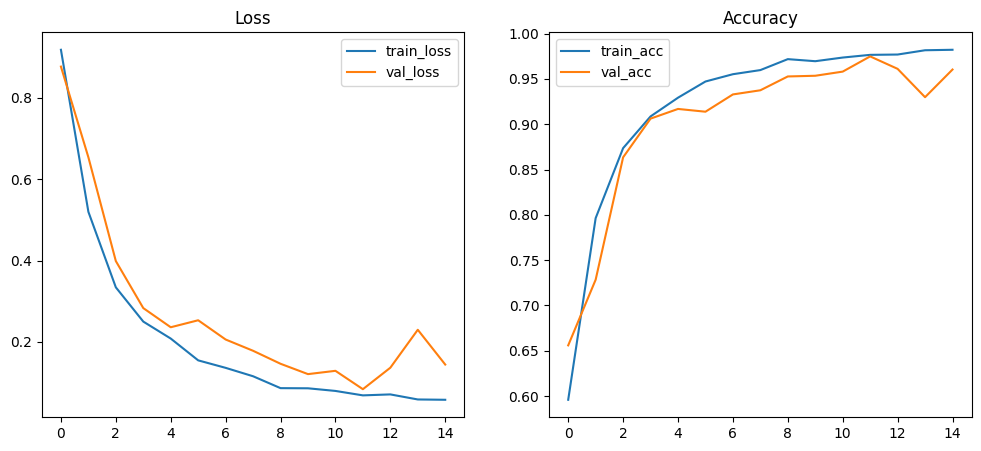

In [20]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input

model = tf.keras.models.Sequential([
    Input(shape=(168, 168, 1)),
    Conv2D(64, 5, activation='relu'),
    MaxPooling2D(3),
    Conv2D(64, 5, activation='relu'),
    MaxPooling2D(3),
    Conv2D(128, 4, activation='relu'),
    MaxPooling2D(2),
    Conv2D(128, 4, activation='relu'),
    MaxPooling2D(2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax'),
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.8, patience=4, min_lr=1e-4
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras', save_best_only=True, monitor='val_accuracy'
    )
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

model = tf.keras.models.load_model('best_model.keras')
loss, acc = model.evaluate(test_ds)
print(f"Test accuracy: {acc * 100:.2f}%")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.show()

In [25]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the entire test set
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))      # Convert one-hot to class index
    y_pred.extend(np.argmax(preds, axis=1))

# Print classification report
from sklearn.metrics import classification_report

target_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
print(classification_report(y_true, y_pred, target_names=target_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━